# Strategies Beyond Diversification

This document provides a comprehensive guide exploring various methodologies and strategies in portfolio optimization. It begins with a detailed examination of the limitations and benefits of portfolio diversification, discussing elements that diversification addresses and fails to address. It also includes a thorough analysis of rolling returns and the calculation of rolling correlations. The guide then transitions into risk mitigation strategies, focusing heavily on Constant Proportion Portfolio Insurance (CPPI), explaining its principles, asset allocation, and dynamic drawdown constraints. A significant portion of the document is dedicated to the simulation of random walks using Geometric Brownian Motion, providing a theoretical overview, practical applications, and interactive simulations to demonstrate stock price behavior and CPPI strategies. The document uses Python libraries and tools like PortfolioOptimizationKit for demonstration and is designed for readers with an interest in financial modeling and portfolio optimization.

===

## Table of Contents

[**Constraints of Portfolio Diversification**](#constraints-of-portfolio-diversification)

- [Formulating the Index](#formulating-the-index)
- [Analyzing Rolling Returns](#analyzing-rolling-returns)
- [Calculating Rolling Correlations: Multi-Indices and Groupby](#calculating-rolling-correlations-multi-indices-and-groupby)

[**Strategies for Risk Mitigation**](#strategies-for-risk-mitigation)

- [Constant Proportion Portfolio Insurance (CPPI)](#constant-proportion-portfolio-insurance-cppi)
  - [Risky Asset Allocation](#risky-asset-allocation)
- [Executing CPPI with Drawdown Limitation](#executing-cppi-with-drawdown-limitation)
- [Implementing the Dynamic Drawdown Constraint](#implementing-the-dynamic-drawdown-constraint)

[**Generating Random Walks with Geometric Brownian Motion**](#generating-random-walks-with-geometric-brownian-motion)

- [Constraints of Portfolio Diversification](#constraints-of-portfolio-diversification)
  - [Formulating the Index](#formulating-the-index)
  - [Analyzing Rolling Returns](#analyzing-rolling-returns)
  - [Calculating Rolling Correlations: Multi-Indices and Groupby](#calculating-rolling-correlations-multi-indices-and-groupby)
- [Strategies for Risk Mitigation](#strategies-for-risk-mitigation)
  - [Constant Proportion Portfolio Insurance (CPPI)](#constant-proportion-portfolio-insurance-cppi)
    - [Risky Asset Allocation](#risky-asset-allocation)
  - [Executing CPPI with Drawdown Limitation](#executing-cppi-with-drawdown-limitation)
  - [Implementing the Dynamic Drawdown Constraint](#implementing-the-dynamic-drawdown-constraint)
- [Generating Random Walks with Geometric Brownian Motion](#generating-random-walks-with-geometric-brownian-motion)
  - [Wiener Process Overview](#wiener-process-overview)
  - [Geometric Brownian Motion (GBM)](#geometric-brownian-motion-gbm)
    - [Returns](#returns)
    - [Log-Returns and Price Evolution](#log-returns-and-price-evolution)
    - [Interactive Simulation of Geometric Brownian Motion](#interactive-simulation-of-geometric-brownian-motion)
    - [Interactive CPPI Simulation - Monte Carlo](#interactive-cppi-simulation---monte-carlo)

</div>

This segment employs Python libraries to illustrate fundamental principles of Portfolio Optimization:

In [1]:
# Standard libraries for data handling and numerical operations
import pandas as pd  # For data manipulation
import numpy as np  # For numerical operations

# Libraries for plotting and visualization
import matplotlib.pyplot as plt  # For plotting graphs

# Import the font manager from matplotlib for managing fonts
import matplotlib.font_manager as font_manager

import seaborn as sns  # For advanced visualization styles

# Additional libraries for statistical analysis and optimization
import scipy.stats  # For statistical functions
from scipy.optimize import minimize  # For optimization functions

# Libraries for fetching financial data and handling date/time
import yfinance as yf  # For fetching financial data using yfinance
from pandas_datareader import data  # For fetching financial data
from datetime import datetime  # For handling date and time objects

# Import tabulate for creating tables
from tabulate import tabulate

# Custom toolkit for portfolio optimization
import sys
sys.path.append("../../")  # Adding the toolkit's directory to system path
import PortfolioOptimizationKit as pok  # Custom toolkit for portfolio optimization

# Setting the plot style for visual consistency
sns.set_style("dark")  # Setting the plot style for Seaborn

In [2]:
# This line loads the autoreload extension in Jupyter.
# Autoreload helps automatically reload imported modules before executing code,
# ensuring that changes in the modules are reflected without restarting the kernel.
%load_ext autoreload

# This line configures the autoreload extension to reload all modules (not just those listed in %aimport)
# every time code is executed. '2' is the mode of autoreload that ensures this behavior.
%autoreload 2

# This line sets up the Jupyter notebook to display matplotlib plots inline.
# This means that generated plots will appear directly below the code cell that produced them.
%matplotlib inline

In [3]:
# Define the relative paths to the font files from the current working directory
montserrat_font_path = "../../toolbox/font/Montserrat-ExtraBold.ttf"
paytone_font_path = "../../toolbox/font/PaytoneOne.ttf"
sourcesanspro_font_path = "../../toolbox/font/SourceSansProSemiBold.ttf"

# Set the Montserrat-ExtraBold font properties
montserrat_font = font_manager.FontProperties(fname=montserrat_font_path, size=12)

# Set the PaytoneOne font properties
paytone_font = font_manager.FontProperties(fname=paytone_font_path, size=11)

# Set the SourceSansPro font properties
sourcesanspro_font = font_manager.FontProperties(fname=sourcesanspro_font_path, size=10)

## Constraints of Portfolio Diversification

- **Elements that diversification successfully addresses**:

  - The approach to augment the reward for each unit of risk;
  - The method to reduce idiosyncratic or specific risk: indeed, it enables investors to diminish specific risks within their portfolios, which is how they can achieve a high reward for each unit of risk.

- **Elements that diversification fails to address**:

  - Diversification is not a viable strategy to reduce systemic risk: essentially, if the entire market collapses, the degree of portfolio diversification becomes irrelevant as correlation levels typically rise and the benefits of diversification diminish.

Subsequently, the intent is to illustrate the aforementioned aspect, specifically that during significant financial downturns, portfolio diversification does not ensure reduced risk.

Proceed to load the subsequent dataset featuring 30 Industry portfolios from Kaggle:

In [11]:
nind = 30

ind_rets   = pok.get_ind_file(filetype="rets", nind=nind)  # Retrieving industry returns
ind_nfirms = pok.get_ind_file(filetype="nfirms", nind=nind)  # Accessing the number of firms per industry
ind_size   = pok.get_ind_file(filetype="size", nind=nind)  # Gathering average industry sizes

ind_rets.head(3)  # Displaying the first three entries of industry returns

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,0.0056,-0.0519,0.0129,0.0293,0.1097,-0.0048,0.0808,0.0177,0.0814,0.0039,...,0.0083,0.0922,0.0206,0.0770,0.0193,-0.2379,0.0007,0.0187,0.0037,0.0520
1926-08,0.0259,0.2703,0.0650,0.0055,0.1001,-0.0358,-0.0251,0.0425,0.0550,0.0814,...,0.0217,0.0202,0.0439,-0.0238,0.0488,0.0539,-0.0075,-0.0013,0.0446,0.0676
1926-09,0.0116,0.0402,0.0126,0.0658,-0.0099,0.0073,-0.0051,0.0069,0.0533,0.0231,...,0.0241,0.0225,0.0019,-0.0554,0.0005,-0.0787,0.0025,-0.0056,-0.0123,-0.0386


The **`ind_rets`** dataframe encompasses returns (spanning 1926-2018) of $30$ portfolios covering various industry sectors such as food, beer, smoke, etc.

These portfolios are formulated based on weights corresponding to their market capitalizations.
The **`market capitalization`** of an entity is its **`total valuation`**, calculated as
the product of the company's outstanding share count and the share price
(e.g., if company "A" has 100,000 shares at $20.3 each, its market cap is $2,030,000).

For instance, the **`Food`** column represents the returns of a portfolio comprising all companies within the food sector for each month from 1926 to 2019. Each company is weighted according to its market capitalization within this portfolio.

Next, the **`number of firms`** comprising each individual sector is recorded in **`ind_nfirms`**:

In [12]:
ind_nfirms.head(3)

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,43.0,3.0,16.0,7.0,2.0,8.0,12.0,7.0,17.0,13.0,...,5.0,3.0,7.0,6.0,74.0,2.0,33.0,6.0,12.0,4.0
1926-08,43.0,3.0,16.0,7.0,2.0,8.0,12.0,7.0,17.0,13.0,...,5.0,3.0,7.0,6.0,74.0,2.0,33.0,6.0,12.0,4.0
1926-09,43.0,3.0,16.0,7.0,2.0,8.0,12.0,7.0,17.0,13.0,...,5.0,3.0,7.0,6.0,74.0,2.0,33.0,6.0,12.0,4.0


indicating that in July 1926, there were 43 companies in the Food portfolio, 3 in the Beer portfolio, etc.

Lastly, the **`ind_size`** dataframe presents the **`average size`** of the companies within each portfolio:


In [13]:
ind_size.head(3)

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,35.98,7.12,59.72,26.41,12.02,22.27,18.36,25.52,57.59,6.18,...,350.36,13.60,56.70,35.35,66.91,1.19,46.65,10.82,18.83,24.25
1926-08,36.10,6.75,60.47,27.17,13.33,22.13,19.83,25.80,62.13,6.20,...,353.27,14.75,57.74,37.86,67.99,0.90,46.57,11.00,18.88,25.51
1926-09,37.00,8.58,64.03,27.30,14.67,21.18,19.29,26.73,65.53,6.71,...,360.96,15.05,59.61,36.82,71.02,0.95,46.11,10.94,19.67,27.21


illustrating that the average size of the 43 Food companies in July 1926 was 35.98, while the average size of the 3 Beer companies was 7.12, and so on (the unit of measurement is arbitrary). Here, **`average size`** refers to the **`mean of the market capitalizations`** of the companies within sectors like Food, Beer, etc.

### Formulating the Index

The initial step is to calculate the **`market capitalization for each industry sector`**.
This is determined by multiplying the number of firms by their average size:

In [15]:
# Calculate the market capitalization for each sector
ind_mkt_cap = ind_nfirms * ind_size
ind_mkt_cap.head(3)

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,1547.14,21.36,955.52,184.87,24.04,178.16,220.32,178.64,979.03,80.34,...,1751.80,40.80,396.90,212.10,4951.34,2.38,1539.45,64.92,225.96,97.00
1926-08,1552.30,20.25,967.52,190.19,26.66,177.04,237.96,180.60,1056.21,80.60,...,1766.35,44.25,404.18,227.16,5031.26,1.80,1536.81,66.00,226.56,102.04
1926-09,1591.00,25.74,1024.48,191.10,29.34,169.44,231.48,187.11,1114.01,87.23,...,1804.80,45.15,417.27,220.92,5255.48,1.90,1521.63,65.64,236.04,108.84


The next objective is to ascertain the **`total market capitalization`** to derive the proportion of the
total market capitalization attributed to each industry. The total market capitalization
is a singular time series **`indicating the aggregate market value at each month`**.
This is achieved by summing the market capitalization of each sector for every month, i.e.,
by horizontally summing the **`ind_mkt_cap`**:

In [17]:
# Summing across sectors to get the total market capitalization at each time point
total_mkt_cap = ind_mkt_cap.sum(axis=1)
total_mkt_cap.head()

1926-07    26657.94
1926-08    27436.34
1926-09    28060.41
1926-10    28057.23
1926-11    27198.40
Freq: M, dtype: float64

Then, the proportion of each industry's market cap to the total can be calculated:

In [19]:
# Calculating the weight of each industry's market cap in the total market capitalization
ind_cap_weights = ind_mkt_cap.divide(total_mkt_cap, axis=0)
ind_cap_weights.head(3)

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,0.058037,0.000801,0.035844,0.006935,0.000902,0.006683,0.008265,0.006701,0.036726,0.003014,...,0.065714,0.001531,0.014889,0.007956,0.185736,0.000089,0.057748,0.002435,0.008476,0.003639
1926-08,0.056578,0.000738,0.035264,0.006932,0.000972,0.006453,0.008673,0.006583,0.038497,0.002938,...,0.064380,0.001613,0.014732,0.008280,0.183379,0.000066,0.056014,0.002406,0.008258,0.003719
1926-09,0.056699,0.000917,0.036510,0.006810,0.001046,0.006038,0.008249,0.006668,0.039700,0.003109,...,0.064318,0.001609,0.014870,0.007873,0.187292,0.000068,0.054227,0.002339,0.008412,0.003879


For instance, in July 1926, the total market capitalization was $\$26,657.94$, with the Food sector comprising approximately $5.8\%$,
the Beer sector approximately $0.08\%$, and so forth.

Visualization of these components is as follows:

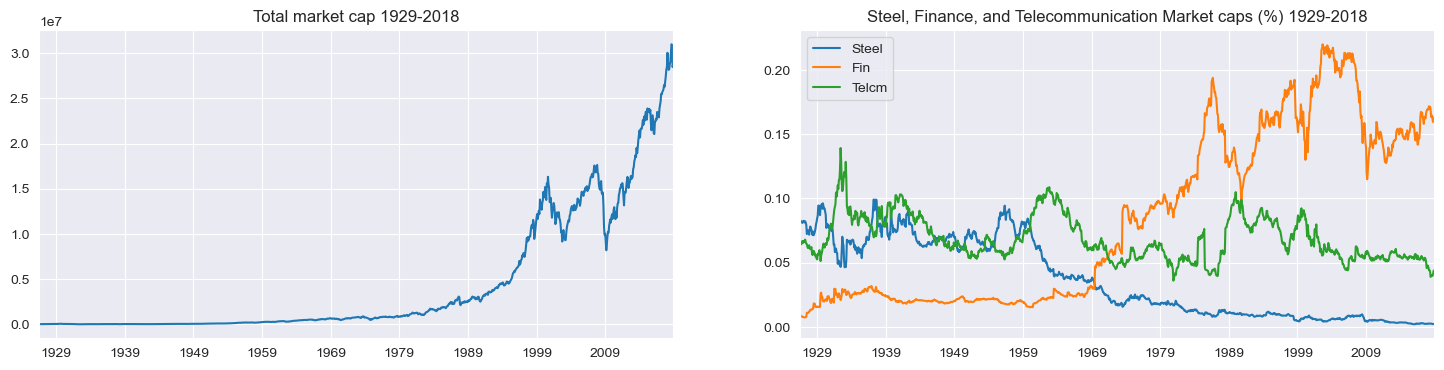

In [20]:
# Creating plots to visualize the total market capitalization and the weights of selected sectors over time
fig, ax = plt.subplots(1,2,figsize=(18,4)) 
total_mkt_cap.plot(grid=True, ax=ax[0]) 
ax[0].set_title("Total market cap 1929-2018")

ind_cap_weights[["Steel","Fin","Telcm"]].plot(grid=True, ax=ax[1])
ax[1].set_title("Steel, Finance, and Telecommunication Market caps (%) 1929-2018")
plt.show()

The left plot displays the total market capitalization from 1929 to 2018. The right plot shows the Steel, Finance, and Telecommunication Market
caps from 1929 to 2018 as a percentage of the total market capitalization.

For instance, observe the change in the Finance sector from about $3%$ of the total market cap in 1929 to over $15%$ in 2018.
Conversely, the Steel sector decreased from around $9%$ in 1929 to $0.2%$ in 2018.

Now, the focus shifts to calculating the **`total market return`**, i.e., the return time series for the total market.
This is the sum of the weighted returns of each sector:

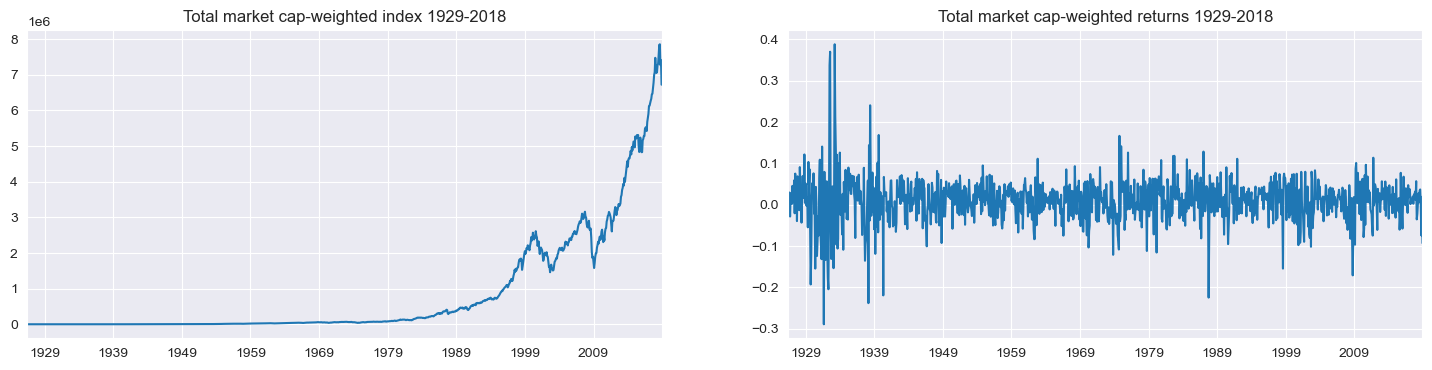

In [21]:
# Calculating the total market return by weighting each sector's monthly returns
total_market_return = (ind_cap_weights * ind_rets).sum(axis=1)

# Assuming an initial investment of 1000$
capital = 1000
# Compounding the returns to get the total market index
total_market_index = capital * (1 + total_market_return).cumprod()

# Visualizing the total market index and returns over time
fig, ax = plt.subplots(1,2,figsize=(18,4)) 

total_market_index.plot(grid=True, ax=ax[0]) 
ax[0].set_title("Total market cap-weighted index 1929-2018")

total_market_return.plot(grid=True, ax=ax[1])
ax[1].set_title("Total market cap-weighted returns 1929-2018")

plt.show()

Note that the plot of the (cap-weighted) index essentially mirrors the plot of the total market capitalization, albeit with different values.

Finally, the aim is to explore **`the relationship between returns and market correlations`**.

### Analyzing Rolling Returns

This section plots the total market index from 1990 onwards, alongside several moving average (MA) series corresponding to 60, 36, and 12 months, respectively. This aims to demonstrate how the **`.rolling`** method functions in Python.

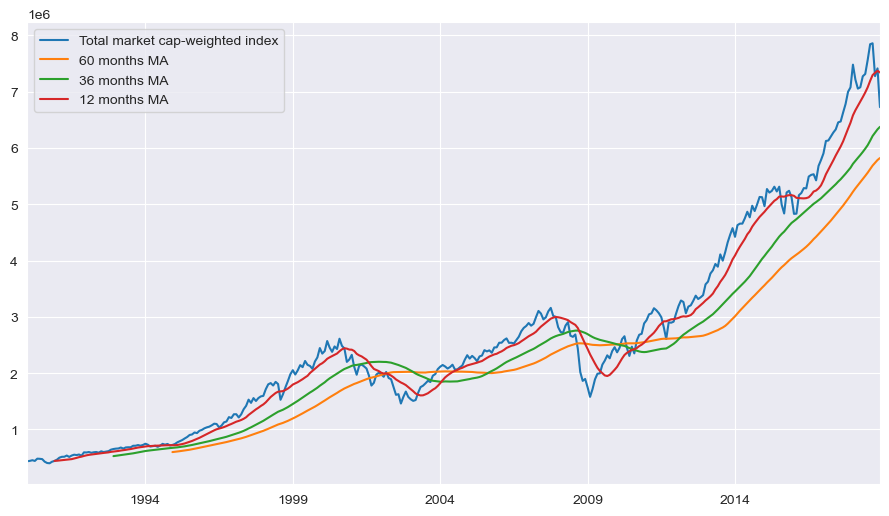

In [22]:
# Plotting the total market cap-weighted index from 1990 onwards
total_market_index["1990":].plot(grid=True, figsize=(11,6), label="Total market cap-weighted index")

# Plotting moving averages over different window sizes to observe trends over time
total_market_index["1990":].rolling(window=60).mean().plot(grid=True, figsize=(11,6), label="60 months MA")  # 5 years MA
total_market_index["1990":].rolling(window=36).mean().plot(grid=True, figsize=(11,6), label="36 months MA")  # 3 years MA
total_market_index["1990":].rolling(window=12).mean().plot(grid=True, figsize=(11,6), label="12 months MA")  # 1 year MA

plt.legend()  # Adding legend to the plot
plt.show()  # Displaying the plot

Next, the trailing 36 months compound returns of the total market return are computed. This is done by opening a rolling window for 36 months and, for each window, compounding the returns using **`.aggregate`**.

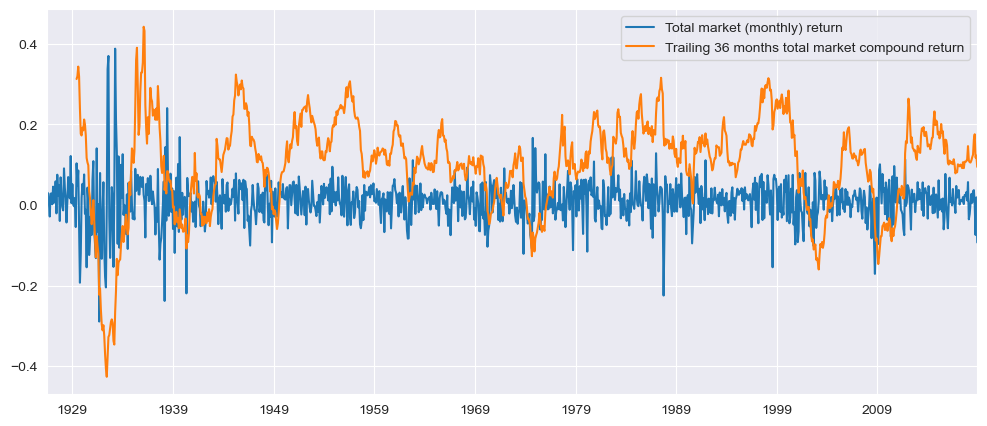

In [23]:
# Calculating trailing 36 months compound returns of total market return
tmi_trail_36_rets = total_market_return.rolling(window=36).aggregate(pok.annualize_rets, periods_per_year=12)

# Plotting the original total market returns alongside the trailing 36 months compound returns
total_market_return.plot(grid=True, figsize=(12,5), label="Total market (monthly) return")
tmi_trail_36_rets.plot(grid=True, figsize=(12,5), label="Trailing 36 months total market compound return")
plt.legend()  # Adding legend to the plot
plt.show()  # Displaying the plot

### Calculating Rolling Correlations: Multi-Indices and Groupby

The rolling correlations across industries are computed similarly to the trailing 36 months compound returns, using the **`.corr()`** method for pairwise correlation between columns of the dataframe.

In [24]:
# Computing rolling correlations across industries
rets_trail_36_corr = ind_rets.rolling(window=36).corr()
rets_trail_36_corr.index.names = ["date","industry"]  # Naming the indices for clarity
rets_trail_36_corr.tail()  # Displaying the last few entries

Food      Beer     Smoke     Games     Books     Hshld  \
date    industry                                                               
2018-12 Whlsl     0.474948  0.356983  0.122672  0.510425  0.803362  0.419280   
        Rtail     0.517856  0.406107  0.030283  0.676464  0.636320  0.358336   
        Meals     0.370187  0.385483  0.122007  0.301516  0.520649  0.308216   
        Fin       0.298823  0.192706  0.027593  0.480276  0.694812  0.162690   
        Other     0.436952  0.376565  0.224010  0.331829  0.558072  0.390610   

                     Clths      Hlth     Chems     Txtls  ...     Telcm  \
date    industry                                          ...             
2018-12 Whlsl     0.570071  0.739764  0.785796  0.634197  ...  0.648092   
        Rtail     0.676598  0.714933  0.626034  0.634202  ...  0.562238   
        Meals     0.302176  0.416193  0.520023  0.491726  ...  0.406184   
        Fin       0.425899  0.658468  0.760151  0.577090  ...  0.420863   
        Other     0.467099  0.645035  0.712511  0.520953  ...  0.607868   

                     Servs     BusEq     Paper     Trans     Whlsl     Rtail  \
date    industry                                                               
2018-12 Whlsl     0.567395  0.543362  0.764252  0.829185  1.000000  0.744842   
        Rtail     0.762616  0.628246  0.656510  0.630615  0.744842  1.000000   
        Meals     0.444629  0.399438  0.627113  0.663358  0.643879  0.616947   
        Fin       0.585418  0.517947  0.670936  0.760730  0.746480  0.611883   
        Other     0.460322  0.434487  0.773798  0.756961  0.767652  0.619918   

                     Meals       Fin     Other  
date    industry                                
2018-12 Whlsl     0.643879  0.746480  0.767652  
        Rtail     0.616947  0.611883  0.619918  
        Meals     1.000000  0.502563  0.605226  
        Fin       0.502563  1.000000  0.734837  
        Other     0.605226  0.734837  1.000000  

[5 rows x 30 columns]

The resulting dataframe is a time series of correlation matrices. Each matrix represents the trailing 36 months correlation matrix of compounded returns of the industries for each available data. The structure of the dataframe includes a double index: for each index date, there is a set of index industries.

To observe the averages of all these correlation matrices for each date, group by date and then take the average.

In [25]:
# Calculating the average of all correlation matrices for each date
ind_trail_36_corr = rets_trail_36_corr.groupby(level="date").apply(lambda corrmat: corrmat.values.mean())

Plotting the trailing 36 months total market compound return alongside the trailing 36 months total market return correlations provides insights into the relationship between returns and correlations over time.

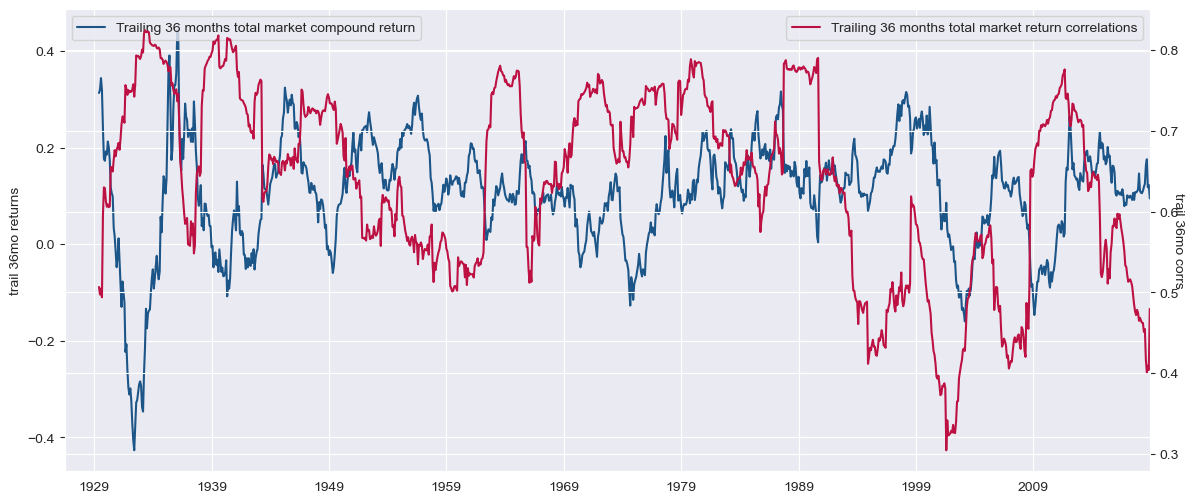

In [27]:
# Plotting the trailing 36 months total market compound return and correlations
fig, ax1 = plt.subplots(1,1,figsize=(14,6))

tmi_trail_36_rets.plot(ax=ax1, color="#1C5588", grid=True, label="Trailing 36 months total market compound return")
ax2 = ax1.twinx()  # Creating a second y-axis
ind_trail_36_corr.plot(ax=ax2, color="#BC1142", grid=True, label="Trailing 36 months total market return correlations")

ax1.set_ylabel('trail 36mo returns')  # Labeling the y-axis
ax2.set_ylabel('trail 36mo corrs',rotation=-90)  # Labeling the second y-axis
ax1.legend(loc=2)  # Positioning the first legend
ax2.legend(loc=1)  # Positioning the second legend
plt.show()  # Displaying the plot

Finally, calculate the correlation between the series of (trailing 36 months) compounded returns and the series of average correlations across industries.

In [28]:
# Calculating the correlation between compounded returns and average correlations across industries
tmi_trail_36_rets.corr(ind_trail_36_corr)

-0.28010065062884026

This correlation is expected to be negative, indicating that as returns fall (especially during market downturns), the average correlation between industries tends to increase, highlighting the limits of diversification during market crashes. Conversely, during periods of market recovery or stability, correlations may decrease, potentially offering more benefits from diversification.

## Strategies for Risk Mitigation

Recent market downturns have underscored the importance of strategies designed for risk control, notably those providing protection against downside risks. This document discusses a fundamental risk insurance strategy before proceeding to more advanced strategies aimed at maximizing upside potential while imposing strict limits on portfolio drawdown.

### Constant Proportion Portfolio Insurance (CPPI)

The **`CPPI`** method enables the realization of option-like (convex) payoffs without the actual use of options.

**Two asset classes are typically involved**: a **`risky asset`**, such as equities or mutual funds, and a **`conservative asset`**, typically cash or treasury bonds.

The strategy revolves around **`dynamic allocation`** between the risky and the safe asset, with the allocation percentage for each dependent on the so-called **`cushion value`**, which is the **`current portfolio value`** minus a predetermined **`floor value`**. Essentially, the cushion is a buffer representing a portion of the current portfolio value that one aims to protect from losses.

**In detail**: the amount allocated to a risky asset is **`a positive integer`** $m$ **`times the cushion`**, while the remainder is allocated to the safe asset. Notably, if the cushion diminishes to zero over time, meaning the portfolio is nearing the floor value, the allocation to the risky asset also drops to zero, effectively shifting the entire capital to the safe asset.

**Example**: Consider an investment in a risky asset with $m=4$ and a floor at $90%$ of the portfolio. The allocation would then be $4*(1-0.9)\% = 40\%$ of the total capital to the risky asset, with the remaining $60\%$ to the safe asset.

#### Risky Asset Allocation

Let $A$ represent the portfolio's value, termed the account value. The allocation to the risky asset is then given by:

$$
E := m (A-F) = m A (1 - f),
$$

where $F:=fA$ denotes the **`floor value`**, with $f$ representing the proportion of wealth one wishes to preserve (e.g., $0.9$ in the prior example).

The **`multiplier`** $m$ **`is typically selected based on the acceptable drop in value`**. For instance, if $F$ is the floor value and $E$ is the amount invested in the risky asset, consider a scenario where the risky asset value decreases by $d%$. **`What should be the value of $m$ to ensure the floor isn't breached?`**

One seeks to satisfy:

$$
\text{account}-\text{loss} = A - dE \geq F = \text{floor value},
$$

where $dE$ is the loss from the risky asset investment and $F$ is the floor value. Substituting, one gets:

$$
A - dmA(1-f) \geq fA
$$

leading to:

$$
1 - dm(1-f) \geq f 
\qquad\Longrightarrow\qquad
m \leq \frac{1}{d}.
$$

This indicates that if $m$ is chosen to be less or equal to $1/d$, the floor will not be breached.

If $m = 1/d$, the account value after the loss equals the floor value, suggesting the entire loss has been absorbed, and the floor has been reached, following:

$$
\text{account}-\text{loss} = A - dE = A - d\frac{1}{d}A(1-f) = fA = \text{floor value},
$$

Selecting $m=6$, for instance, would mean a loss greater than $20\%$ could breach the floor with such a drop.

**Example**: For a $20\%$ drop,

$$
m \leq \frac{1}{0.2} = 5,
$$

meaning the multiplier should ideally be no more than $5$ to avoid breaching the floor.

Generally, if $m%$ is the maximum acceptable loss, then the multiplier should be (at most) $1/m\%$.

### Executing CPPI with Drawdown Limitation

The **`CPPI strategy`**, an algorithmic approach, is predicated on three fundamental steps:

- **`Cushion Calculation`**: Derive the cushion by subtracting the Floor value from the Account value.

- **`Asset Allocation`**: Determine the distribution between the risky and safe assets.

- **`Account Value Update`**: Adjust the account value in response to returns.

This segment details the establishment of this investment strategy utilizing industry returns alongside the total market index returns.

In [29]:
# Fetching industry and total market index returns
ind_return = pok.get_ind_file(filetype="rets", nind=nind)
tmi_return = pok.get_total_market_index_returns(nind=nind)

The focus is narrowed to industry returns post-2000, concentrating on three industries as the risky assets:

In [32]:
# Selecting industry returns from 2000 for three industries
risky_rets = ind_return["2000":][["Steel","Fin","Beer"]]

For the safe asset, an artificial asset is crafted, guaranteeing a $3\%$ annual return:

In [33]:
# Creating a DataFrame for safe asset returns with a fixed 3% annual return
safe_rets    = pd.DataFrame().reindex_like(risky_rets)
safe_rets[:] = 0.03 / 12

Initial account value (investment), floor value, and multiplier are then established:

In [34]:
# Setting initial values and parameters for the CPPI strategy
start_value   = 1000  # Initial investment
account_value = start_value  # Current account value
floor         = 0.8  # Floor as a percentage of the initial account value
floor_value   = floor * account_value  # Absolute floor value
m = 3  # Multiplier, selected based on acceptable drop before breaching the floor

# Initializing DataFrames to track account history, cushion, and risky asset weights
account_history = pd.DataFrame().reindex_like(risky_rets)
cushion_history = pd.DataFrame().reindex_like(risky_rets)
risky_w_history = pd.DataFrame().reindex_like(risky_rets)

Prior to initiating the CPPI strategy, the growth of wealth exclusively invested in risky assets is computed for comparison:

In [36]:
# Calculating the wealth growth for a 100% investment in risky assets
risky_wealth = start_value * (1 + risky_rets).cumprod()
risky_wealth.head()

,Steel,Fin,Beer
2000-01,972.300000,955.800000,977.200000
2000-02,1038.805320,874.652580,863.453920
2000-03,1075.059626,1020.632096,864.576410
2000-04,1066.029125,977.255232,896.392822
2000-05,1013.580492,1026.704346,1002.794650


The CPPI strategy is now executed:

In [37]:
# Implementing the CPPI strategy over time
for step in range(len(risky_rets.index)):
    # Calculating the cushion as a percentage of the current account value
    cushion = (account_value - floor_value) / account_value
    
    # Determining the allocation to the risky asset, ensuring it stays within [0,1]
    risky_w = m * cushion
    risky_w = np.minimum(risky_w, 1)
    risky_w = np.maximum(risky_w, 0)
    
    # Determining the allocation to the safe asset
    safe_w  = 1 - risky_w
    
    # Calculating the value allocation to both the risky and safe assets
    risky_allocation = risky_w * account_value
    safe_allocation  = safe_w  * account_value
    
    # Updating the account value based on returns from both assets
    account_value = risky_allocation * (1 + risky_rets.iloc[step] ) + safe_allocation  * (1 + safe_rets.iloc[step]  )
        
    # Recording the current account value, cushion, and risky asset weights
    account_history.iloc[step] = account_value
    cushion_history.iloc[step] = cushion 
    risky_w_history.iloc[step] = risky_w

# Calculating the returns from the CPPI strategy
cppi_rets = (account_history / account_history.shift(1) - 1).dropna()

The account history resultant from the CPPI strategy is then examined:

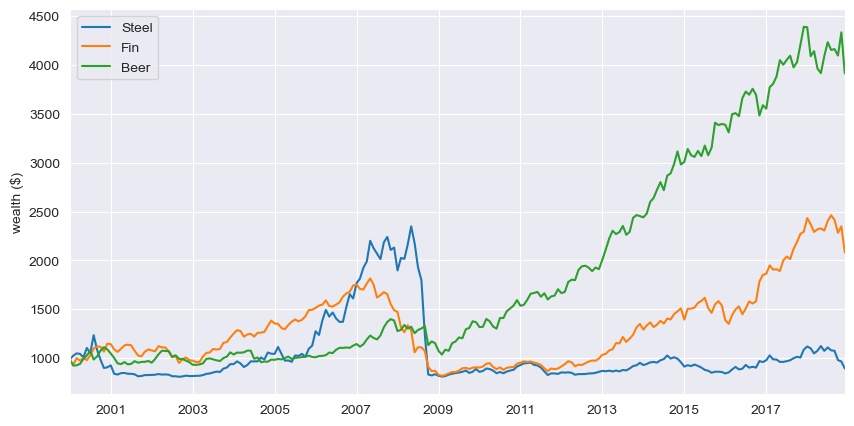

In [38]:
# Plotting the account history to visualize the wealth evolution over time
ax = account_history.plot(figsize=(10,5), grid=True)
ax.set_ylabel("wealth ($)")
plt.show()

A comparative analysis between the CPPI strategies and a full investment in risky assets is conducted:

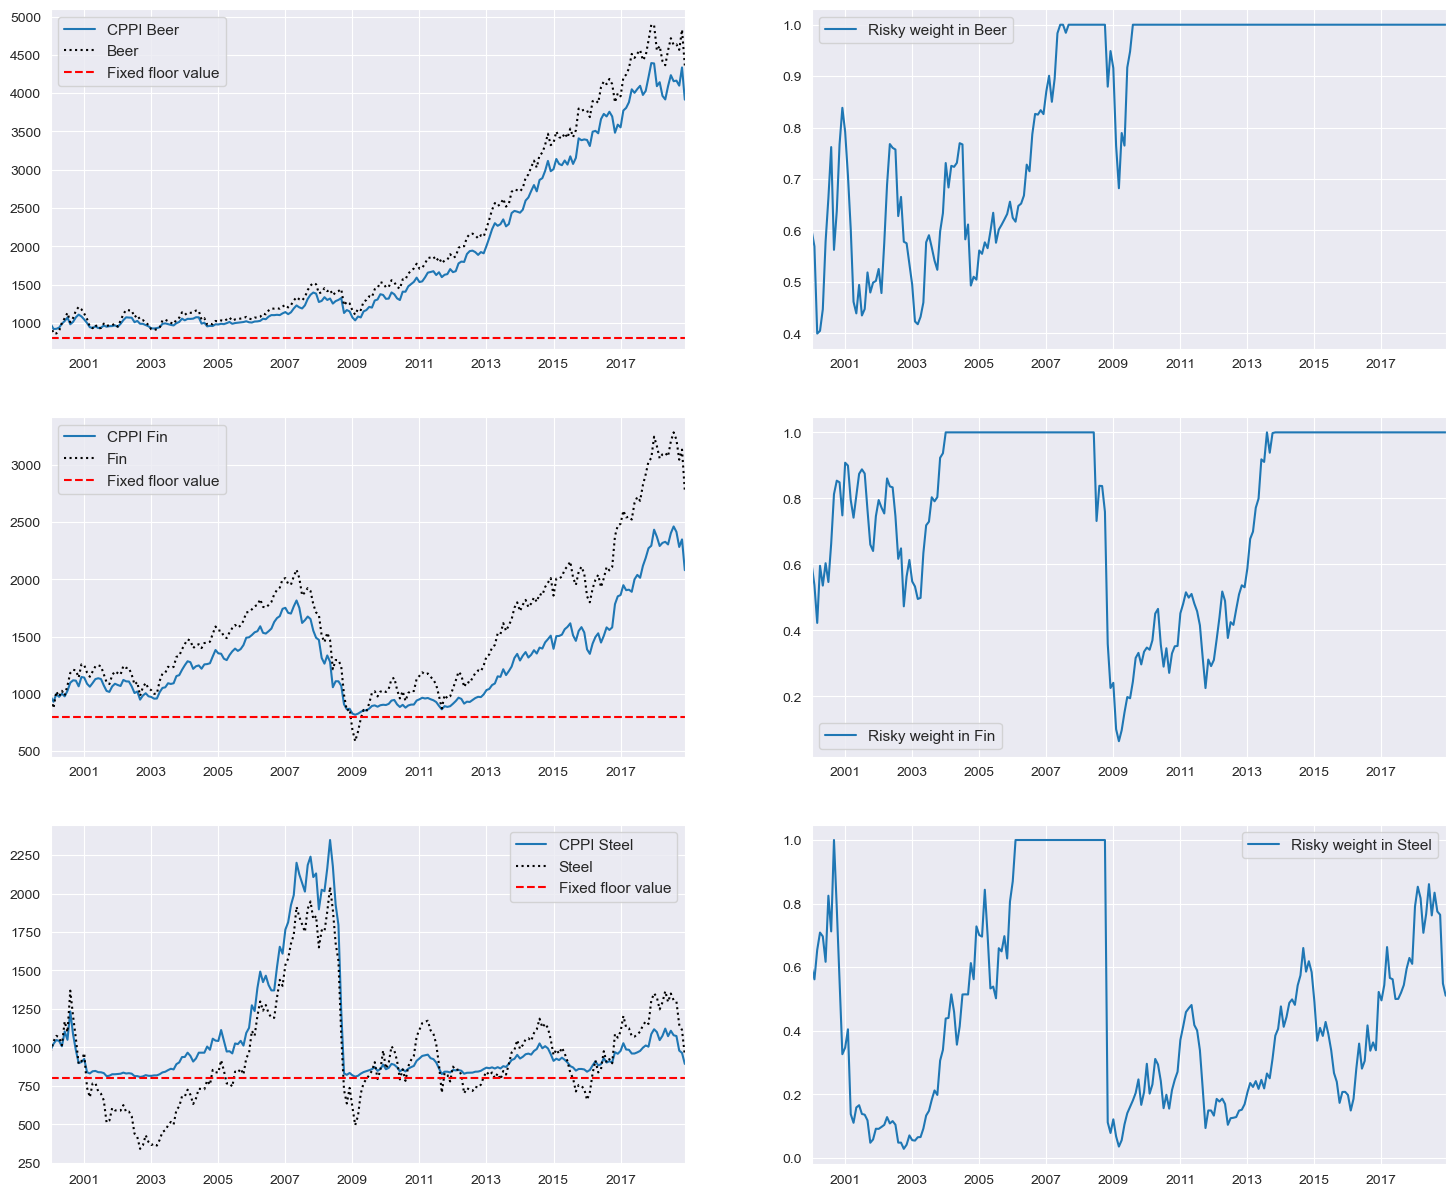

In [39]:
# Setting up the plot for comparative analysis between CPPI strategies and full investment in risky assets
fig, ax = plt.subplots(3,2,figsize=(18,15))
ax = ax.flatten()

# Comparative analysis for 'Beer'
account_history["Beer"].plot(ax=ax[0], grid=True, label="CPPI Beer")
risky_wealth["Beer"].plot(ax=ax[0], grid=True, label="Beer", style="k:")
ax[0].axhline(y=floor_value, color="r", linestyle="--", label="Fixed floor value")
ax[0].legend(fontsize=11)

# Plotting the allocation weights for 'Beer'
risky_w_history["Beer"].plot(ax=ax[1], grid=True, label="Risky weight in Beer")
ax[1].legend(fontsize=11)

# Comparative analysis for 'Fin'
account_history["Fin"].plot(ax=ax[2], grid=True, label="CPPI Fin")
risky_wealth["Fin"].plot(ax=ax[2], grid=True, label="Fin", style="k:")
ax[2].axhline(y=floor_value, color="r", linestyle="--", label="Fixed floor value")
ax[2].legend(fontsize=11)

# Plotting the allocation weights for 'Fin'
risky_w_history["Fin"].plot(ax=ax[3], grid=True, label="Risky weight in Fin")
ax[3].legend(fontsize=11)

# Comparative analysis for 'Steel'
account_history["Steel"].plot(ax=ax[4], grid=True, label="CPPI Steel")
risky_wealth["Steel"].plot(ax=ax[4], grid=True, label="Steel", style="k:")
ax[4].axhline(y=floor_value, color="r", linestyle="--", label="Fixed floor value")
ax[4].legend(fontsize=11)

# Plotting the allocation weights for 'Steel'
risky_w_history["Steel"].plot(ax=ax[5], grid=True, label="Risky weight in Steel")
ax[5].legend(fontsize=11)

plt.show()

As anticipated, during periods of market growth, the CPPI strategy (blue line) typically underperforms a full investment in the risky asset (dotted line). However, the CPPI strategy demonstrates its value during downturns, such as the Lehman Brothers crisis, where it protects the investment from breaching the floor.

Lastly, the statistics for both a pure investment in risky assets and the CPPI strategy are compared:

In [41]:
# Displaying summary statistics for the pure risky asset investment and the CPPI strategy
pok.summary_stats(risky_rets)
pok.summary_stats(cppi_rets)

,Ann. return,Ann. vol,Sharpe ratio,Skewness,Kurtosis,Historic CVar,C-F Var,Max Drawdown
Steel,-0.005167,0.174180,-0.196750,-1.995143,17.110190,0.130153,0.091995,-0.655198
Fin,0.040894,0.131678,0.080352,-0.946504,6.051414,0.091621,0.065535,-0.549673
Beer,0.075544,0.115462,0.383772,-0.669250,4.760879,0.074908,0.052923,-0.259582


Drawdown analysis reveals that while a full investment in risky assets might lead to greater losses, it may also yield higher returns. For instance, investing entirely in **`Beer`** might have returned approximately $8\%$ annually, compared to around $7\%$ from the **`CPPI strategy`**.

### Implementing the Dynamic Drawdown Constraint

In the initial CPPI strategy, the floor value was static.

However, investors typically prefer a strategy where the **`floor value is dynamically updated based on the portfolio's wealth growth`**, specifically relative to the **`previous peak`**. This approach aims to recalibrate the floor value as the portfolio value increases.

The CPPI strategy has been encapsulated into a method within the toolkit. This version incorporates a dynamic drawdown constraint, where the multiplier $m$ is adjusted based on the specified drawdown limit.

Consider an example with a drawdown limit of $20\%$:

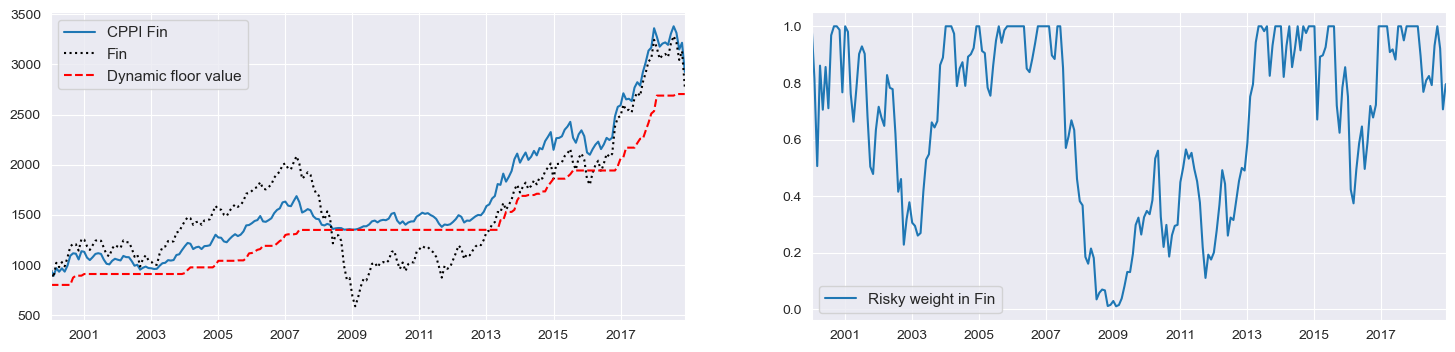

In [42]:
# Running the CPPI with a dynamic drawdown constraint using the toolkit's method
res = pok.cppi(risky_rets, start_value=1000, floor=0.8, drawdown=0.2, risk_free_rate=0.03, periods_per_year=12)

# Selecting a specific sector for analysis
sector = "Fin"

# Plotting the wealth progression of the CPPI strategy alongside the pure investment in the sector and the floor value
fig, ax = plt.subplots(1,2,figsize=(18,4))
ax = ax.flatten()

# Plotting the CPPI wealth and the risky wealth for the selected sector
res["CPPI wealth"][sector].plot(ax=ax[0], grid=True, label="CPPI "+sector)
res["Risky wealth"][sector].plot(ax=ax[0], grid=True, label=sector, style="k:")
res["Floor value"][sector].plot(ax=ax[0], grid=True, color="r", linestyle="--", label="Dynamic floor value")
ax[0].legend(fontsize=11)

# Plotting the allocation to the risky asset over time
res["Risky allocation"][sector].plot(ax=ax[1], grid=True, label="Risky weight in "+sector)
ax[1].legend(fontsize=11)

plt.show()

This code executes the CPPI strategy with a dynamic floor that adapts based on the portfolio's performance and imposes a drawdown constraint.

Next, compare the statistics of the sector's pure risky returns with the returns from the CPPI strategy:

In [43]:
# Displaying the summary statistics for the sector's pure risky returns and the CPPI returns
print("Statistics for sector's pure risky returns:")
print(tabulate(pok.summary_stats(risky_rets[sector]), headers='keys', tablefmt='github'))

print("\nStatistics for CPPI returns:")
print(tabulate(pok.summary_stats(res["CPPI returns"][sector]), headers='keys', tablefmt='github'))

Statistics for sector's pure risky returns:
|    |   Ann. return |   Ann. vol |   Sharpe ratio |   Skewness |   Kurtosis |   Historic CVar |   C-F Var |   Max drawdown |
|----|---------------|------------|----------------|------------|------------|-----------------|-----------|----------------|
|  0 |     0.0551662 |   0.192909 |       0.126718 |  -0.533218 |    4.99553 |        0.132175 | 0.0912242 |      -0.718465 |

Statistics for CPPI returns:
|    |   Ann. return |   Ann. vol |   Sharpe ratio |   Skewness |   Kurtosis |   Historic CVar |   C-F Var |   Max drawdown |
|----|---------------|------------|----------------|------------|------------|-----------------|-----------|----------------|
|  0 |     0.0609057 |   0.103468 |       0.290592 |  -0.162753 |    3.85264 |       0.0616591 | 0.0444896 |      -0.198261 |


The maximum drawdown in the CPPI strategy is expected to be around $19.8\%$ with an annual return of $6\%$. The dynamic adjustment of the multiplier $m$ based on the drawdown constraint ensures that the investment floor is protected during market downturns.

Now, observe the behavior of the CPPI strategy when varying the maximum accepted drawdown:

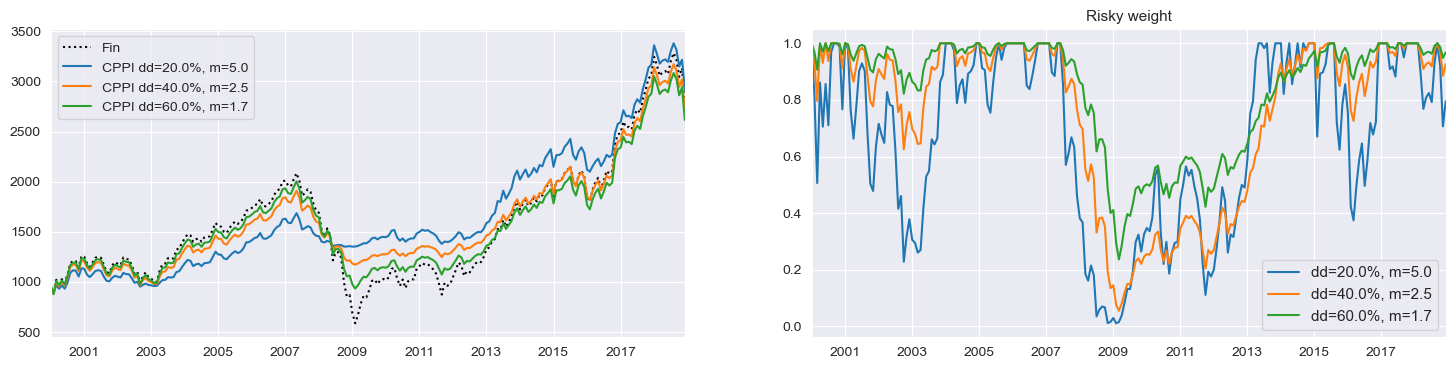

Summary statistics for various drawdown scenarios:
|            |   Ann. return |   Ann. vol |   Sharpe ratio |   Skewness |   Kurtosis |   Historic CVar |   C-F Var |   Max drawdown |
|------------|---------------|------------|----------------|------------|------------|-----------------|-----------|----------------|
| ('DD20%',) |     0.0609057 |   0.103468 |       0.290592 |  -0.162753 |    3.85264 |       0.0616591 | 0.0444896 |      -0.198261 |
| ('DD40%',) |     0.0564708 |   0.122929 |       0.209429 |  -0.10093  |    4.30043 |       0.0768182 | 0.0531064 |      -0.386458 |
| ('DD60%',) |     0.0546423 |   0.142893 |       0.167664 |  -0.300973 |    4.19064 |       0.0914833 | 0.0648671 |      -0.533947 |


In [44]:
# Comparing CPPI strategies with different drawdown constraints
sector = "Fin"
drawdowns = [0.2, 0.4, 0.6]
    
fig, ax = plt.subplots(1,2,figsize=(18,4))
ax = ax.flatten()

# Plotting the risky wealth for comparison
res["Risky wealth"][sector].plot(ax=ax[0], grid=True, style="k:", label=sector)
ax[0].legend()

# Initializing a DataFrame to store summary statistics
summ = pd.DataFrame()

# Analyzing CPPI strategies with various drawdown constraints
for drawdown in drawdowns:
    # Running CPPI with the specified drawdown constraint
    res = pok.cppi(risky_rets, start_value=1000, floor=0.8, drawdown=drawdown, risk_free_rate=0.03, periods_per_year=12)    
    
    # Plotting the CPPI wealth and risky allocation for each drawdown scenario
    res["CPPI wealth"][sector].plot(ax=ax[0], grid=True, label="CPPI dd={}%, m={}".format(drawdown*100,round(res["m"],1)) )
    res["Risky allocation"][sector].plot(ax=ax[1], grid=True, label="dd={}%, m={}".format(drawdown*100,round(res["m"],1)) )
    
    # Appending summary statistics for each scenario
    summ = pd.concat([summ, pok.summary_stats(res["CPPI returns"][sector])], axis=0)
        
# Displaying the plots and summary statistics
ax[0].legend() 
ax[1].legend(fontsize=11)
ax[1].set_title("Risky weight", fontsize=11)
plt.show()

# Setting the index for the summary statistics DataFrame
summ.index = [["DD20%","DD40%","DD60%"]]
print("Summary statistics for various drawdown scenarios:")
print(tabulate(summ, headers='keys', tablefmt='github'))

This code compares the performance and allocation strategy of the CPPI strategy under different drawdown constraints, illustrating how the strategy adapts to various levels of risk tolerance. The summary statistics provide insight into the trade-offs between risk and return for each scenario.

## Generating Random Walks with Geometric Brownian Motion

### Wiener Process Overview

A Wiener process $W_t$ is a continuous-time stochastic process defined by four key characteristics:

1. The process starts at zero: $W_{0}=0$;
2. It has independent increments, meaning future changes $W_{t+u}-W_{t}$, for $u\geq 0$, are independent of past values $W_{s}$, for $s< t$;
3. Has Gaussian increments, meaning increments following a normal distribution with mean 0 and variance $u$ , i.e., $W_{t+u}-W_t \sim{\mathcal {N}}(0,u)$;
4. The process has continuous paths, implying $W_{t}$ varies smoothly over time.

Therefore, $\mathbb{E}[W_t]=0$, $\text{Var}(W_t) = t$ for a fixed time $t$ and the unconditional probability density function of $W_t$ is:

$$
f_{W_{t}}(x) = \frac{1}{ \sqrt{2\pi t} } e^{\frac{-x^2}{2t}}.
$$

### Geometric Brownian Motion (GBM)

A **`stochastic process`** $S_t$ follows a **`Geometric Brownian Motion`** if it adheres to the following **`stochastic differential equation (SDE)`**:

$$
dS_{t} = \mu S_{t}\,dt + \sigma S_t \, dW_{t} 
$$

where $W_{t}$ is a **`Brownian motion`** (i.e. a **`Wiener process`**), $\mu$ represents the **`drift`** (trend), and $\sigma$ represents the **`volatility`**. Both are constants.

#### Returns

By dividing the equation by $S_t$ and $dt$, one can derive a formula for generating percentage returns from a GBM. The returns generated this way have a mean of $\mu dt$ and volatility of $\sigma \sqrt{dt}$.

> 📢 **Remark**
>
> In the given equation, $dS_t = S_{t+dt} - S_t$, and similarly $dW_t = W_{t+dt} - W_t$ for $dt>0$. When this is normalized by $S_t$ the formula becomes:
>
> $$
\frac{S_{t+dt} - S_t}{S_t} = \mu dt + \sigma (W_{t+dt} - W_t).
> $$
>
> Here, the left side represents the **`percentage return`**.
>
> Considering that $W_t$ has Gaussian increments with zero mean and variance $dt$, the increment can be replaced with a normally distributed random variable $\sqrt{dt}\xi_t$, where $\xi_t \sim \mathcal{N}(0,1)$ for all $t$.
>
> This substitution is valid as $\mathbb{E}[\sqrt{dt}\xi_t] = 0$ and $\text{Var}(\sqrt{dt}\xi_t) = dt\text{Var}(\xi_t)=dt$.
>
> The formula thus transforms into:
>
> $$
\frac{S_{t+dt} - S_t}{S_t} = \mu dt + \sigma \sqrt{dt}\xi_t,
\quad\xi_t\sim\mathcal{N}(0,1), \; \forall\; t,
> $$
>
> This expression provides a method to generate (percentage) returns from a geometric Brownian motion. The expected value and variance of these returns are calculated as:
>
> $$
\begin{align}
\mathbb{E}\left[\mu dt + \sigma \sqrt{dt}\xi_t\right] &= \mu dt + \sigma \sqrt{dt} \mathbb{E}[\xi_t] = \mu dt, \\
\text{Var}\left[\mu dt + \sigma \sqrt{dt}\xi_t\right] &= \sigma^2 dt \text{Var}(\xi_t) = \sigma^2 dt,
\end{align}
> $$
>
> indicating that the generated returns have a mean of $\mu dt$ and volatility of $\sigma\sqrt{dt}$.

#### Log-Returns and Price Evolution

For log-returns, approximations using Taylor series expansions lead to:

$$
\log\left(\frac{S_{t+dt}}{S_t}\right) \approx \left(\mu - \frac{\sigma^2}{2}\right)dt + \sigma\sqrt{dt}\xi_t,
$$

where $\xi_t \sim \mathcal{N}(0,1)$. This simplifies the calculation of prices and returns over time.

The price evolution of a stock, for example, can be modeled using the GBM formula:

$$
S_t = S_0\exp\left(\left(\mu - \frac{\sigma^2}{2}\right)t + \sigma W_t\right).
$$

> 📢 **Remark**
>
> Considering the stochastic differential equation and dividing by $dt$, one obtains:
>
> $$
\frac{dS_t}{dt} = S_t\left(\mu + \sigma\frac{dW_t}{dt}\right),
> $$
>
> which delineates the process's evolution over time. For instance, the process $S_t$ might represent a stock price. This equation can be resolved through the subsequent reasoning.
>
> Initially, it is recognized that:
>
> $$
\log(1+x) \approx x - \frac{x^2}{2},
> $$
>
> particularly when $x$ is adequately small. Thus:
>
> $$
\begin{aligned}
\log\left(\frac{S_{t+dt}}{S_t}\right) &= \log\left(1 + \frac{S_{t+dt} - S_t}{S_t}\right) \\
&\approx \mu dt + \sigma\sqrt{dt}\xi_t - \frac{1}{2}\left(\mu dt + \sigma\sqrt{dt}\xi_t\right)^2 \\
&\approx \mu dt + \sigma\sqrt{dt}\xi_t - \frac{1}{2}\sigma^2 dt = \left(\mu - \frac{\sigma^2}{2}\right)dt + \sigma\sqrt{dt}\xi_t.
\end{aligned}
> $$
>
> The term on the left-hand side of the above equation is termed the log-return and it adheres to a dynamic akin to the classic percentage return. The key distinction lies in the scaled drift $(\mu-\sigma^2/2)$ featured in the log-return equation.
>
> Exponentiating both sides yields:
>
> $$
S_{t+dt} \approx S_t\exp\left(\left(\mu - \frac{\sigma^2}{2}\right)dt + \sigma\sqrt{dt}\xi_t\right).
> $$
>
> To deduce the solution, it is noted that for each unit $t = ndt$, where $n\in\mathbb{N}$, it follows that:
>
> $$
S_t = S_{0+ndt} \approx S_0\exp\left(\left(\mu - \frac{\sigma^2}{2}\right)(ndt) + \sigma\sqrt{ndt}\xi_t\right) = S_0\exp\left(\left(\mu - \frac{\sigma^2}{2}\right)t + \sigma\sqrt{t}\xi_t\right) = S_0\exp\left(\left(\mu - \frac{\sigma^2}{2}\right)t + \sigma W_t\right).
> $$
>
> This equation describes the evolution of, for example, a stock price starting from an initial price $S_0$.

Within the toolkit, there are two functions that generate stock prices based on the above principles: one by compounding percentage returns following a GBM and another by resolving the GBM equation for log-returns:

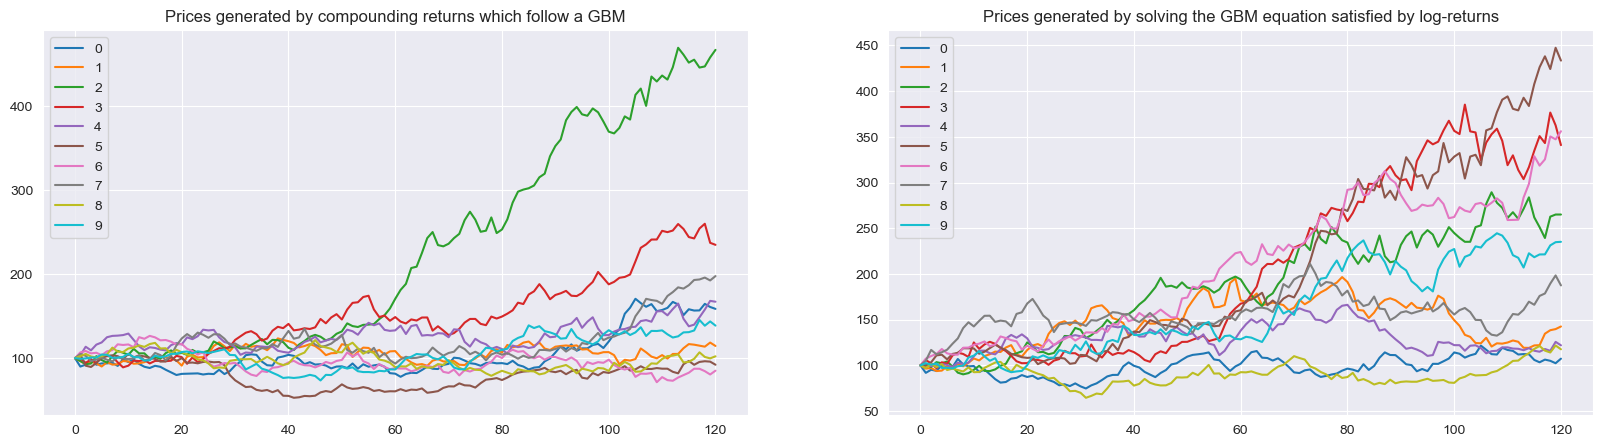

In [45]:
prices_1, rets_1 = pok.simulate_gbm_from_returns(n_years=10, n_scenarios=10, mu=0.07, sigma=0.15, periods_per_year=12, start=100.0)
prices_2, rets_2 = pok.simulate_gbm_from_prices(n_years=10, n_scenarios=10, mu=0.07, sigma=0.15, periods_per_year=12, start=100.0)

fig, ax = plt.subplots(1, 2, figsize=(20,5))
prices_1.plot(ax=ax[0], grid=True, title="Prices generated by compounding returns which follow a GBM")
prices_2.plot(ax=ax[1], grid=True, title="Prices generated by solving the GBM equation satisfied by log-returns")
plt.show()

Occasionally, the drift $\mu$ in the geometric Brownian motion is decomposed to accentuate the risk-free rate, the volatility, and the Sharpe ratio. Specifically, the Sharpe ratio of a stock index is defined as:

$$
\text{SR} := \lambda = \frac{R_s - R_f}{\sigma} \quad\Longrightarrow\quad R_s = R_f + \sigma \lambda,
$$

where $\sigma$ denotes the stock index's volatility, $R_f$ the risk-free rate, and $R_s$ the stock index's annualized return.

This reveals that $\mu$, representing the expected return of the stock index being modeled, is essentially the risk-free rate $R_f$ plus a risk premium, composed of the unit of risk, i.e., volatility $\sigma$, and the reward per unit of risk, i.e., the Sharpe ratio $\lambda$.

Consequently, the geometric Brownian motion for (percentage) returns with $\mu$ replaced is:

$
\frac{dS_t}{S_t} = (R_f + \sigma \lambda) dt + \sigma dW_t.
$

#### Interactive Simulation of Geometric Brownian Motion

Interactive plots can be created using **`ipywidgets`**, which provides a way to generate dynamic plots. Below is a demonstration of creating interactive plots for simulating random walks:

First, the necessary library is imported:

In [46]:
import ipywidgets as widgets

The function **`show_gbm`** is designed to generate random walks by invoking the **`simulate_gbm_from_returns`** method from the **`pok`** (PortfolioOptimizationKit) toolkit. It then plots these random prices, with the widget adding a layer of interactivity:

In [47]:
gbm_controls = widgets.interact(pok.show_gbm, 
                                n_years=(1, 10, 1),  # Slider for number of years
                                n_scenarios=(1, 100, 1),  # Slider for number of scenarios
                                mu=(-0.30, 0.30, 0.01),  # Slider for drift (mu)
                                sigma=(0.0, 0.50, 0.01),  # Slider for volatility (sigma)
                                periods_per_year=[12, 52, 252],  # Dropdown for periods per year
                                start=[100]  # Initial start price
                               )

interactive(children=(IntSlider(value=10, description='n_years', max=10, min=1), IntSlider(value=10, descripti…

> 📢 **Note**
>
> *To use ipywidgets effectively, it's generally recommended to run this code within a Jupyter notebook environment. Jupyter provides the necessary interactive frontend to render and manipulate the widgets effectively.*

**`Geometric Brownian Motion`** (GBM) is a widely adopted model for stock price behavior, especially in the **`Black–Scholes model`** for options pricing.

**Arguments in favor of using GBM for stock price modeling include:**

- GBM's expected returns are independent of the value of the process (stock price), aligning with real-world expectations.
- GBM only assumes positive values, similar to real stock prices.
- GBM paths show a level of 'roughness' akin to actual stock price movements.
- GBM processes are relatively straightforward to compute.

**However, GBM does not fully encapsulate the complexities of real stock prices**:

- Real stock prices exhibit volatility that changes over time, sometimes stochastically, whereas GBM assumes constant volatility.
- Real-life stock prices show jumps due to sudden news or events, but GBM assumes a continuous path.

#### Interactive CPPI Simulation - Monte Carlo

This segment introduces the **`show_cppi`** method from the **`pok`** toolkit, which simulates a Constant Proportion Portfolio Insurance (CPPI) investment strategy based on returns generated by Geometric Brownian Motion. It focuses on a fixed-floor scenario, specifically without a drawdown constraint.

The interactive plot is facilitated using the **`interact`** widget:

In [48]:
cppi_controls = widgets.interact(pok.show_cppi, 
                                 n_years=(1, 10, 1),  # Slider for number of years
                                 n_scenarios=(1, 300, 1),  # Slider for number of scenarios
                                 m=(1, 6, 0.5),  # Slider for multiplier (m)
                                 floor=(0.0, 1.0, 0.05),  # Slider for floor value
                                 mu=(-0.2, 0.4, 0.01),  # Slider for drift (mu)
                                 sigma=(0.0, 0.5, 0.01),  # Slider for volatility (sigma)
                                 risk_free_rate=(0.01, 0.05, 0.01),  # Slider for risk-free rate
                                 periods_per_year=[12, 52, 252],  # Dropdown for periods per year
                                 start=[100],  # Initial start price
                                 ymax=widgets.IntSlider(min=0, max=100, value=100, step=1, description="Zoom Y axis")  # Slider to zoom Y axis
                               )

interactive(children=(IntSlider(value=10, description='n_years', max=10, min=1), IntSlider(value=50, descripti…

CPPI is a methodology ensuring a certain investment floor is preserved while allowing exposure to potential upside. The provided sliders and inputs allow users to interactively experiment with various parameters and observe their effects on the CPPI strategy's outcomes.

It is important to note that to see the interactive elements in action, running the script in a Jupyter notebook is necessary as Jupyter provides the interactive interface required for ipywidgets. Running these widgets in a standard script or terminal won't produce the interactive visualizations. For those using environments like VSCode, Jupyter notebook support is generally integrated, allowing for the execution and interaction with these widgets within the editor itself.
